# TORONTO AUTO THEFT ANALYSIS (2014 - 2024)


In [313]:
#Import pandas and load data
import pandas as pd

cols = ['EVENT_UNIQUE_ID', 'REPORT_YEAR', 'REPORT_MONTH', 'REPORT_DOW', 'REPORT_HOUR',
        'OCC_DOW', 'OCC_HOUR', 'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'HOOD_158', 'NEIGHBOURHOOD_158',
        'LONG_WGS84', 'LAT_WGS84', 'x', 'y']
auto_theft_data = pd.read_csv('Auto_Theft_Toronto.csv', usecols=cols)
auto_theft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70163 entries, 0 to 70162
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EVENT_UNIQUE_ID    70163 non-null  object 
 1   REPORT_YEAR        70163 non-null  int64  
 2   REPORT_MONTH       70163 non-null  object 
 3   REPORT_DOW         70163 non-null  object 
 4   REPORT_HOUR        70163 non-null  int64  
 5   OCC_DOW            70159 non-null  object 
 6   OCC_HOUR           70163 non-null  int64  
 7   DIVISION           70163 non-null  object 
 8   LOCATION_TYPE      70163 non-null  object 
 9   PREMISES_TYPE      70163 non-null  object 
 10  HOOD_158           70163 non-null  object 
 11  NEIGHBOURHOOD_158  70163 non-null  object 
 12  LONG_WGS84         70163 non-null  float64
 13  LAT_WGS84          70163 non-null  float64
 14  x                  70163 non-null  float64
 15  y                  70163 non-null  float64
dtypes: float64(4), int64(3

# Generate a visualization to show the number of reported auto theft per year.

Group data by year and count the number of reported incidents.

Note: Year 2025 data is not included in graph as data available till Mar-31.

In [314]:
#Filtering data until 2024 as 2025 data entire year data is not available
auto_theft_data_filtered = auto_theft_data[auto_theft_data['REPORT_YEAR'] < 2025]

##Groupby year and count number of entries per year
theft_by_year = auto_theft_data_filtered.groupby('REPORT_YEAR').size().reset_index(name='THEFT_COUNT')
theft_by_year.set_index('REPORT_YEAR', inplace=True)
#Create year list as list string
years_list = list(map(str, theft_by_year.index.tolist()))

Plot the data frame using Bokeh

In [315]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, Legend, LegendItem
from bokeh.models import CrosshairTool
from bokeh.palettes import cividis, YlOrRd9, Category20, Blues
import math

output_notebook()
colors = [Blues[256][x*20] for x in range(1, 12)]
plot_year = figure(title='Total auto thefts per year 2014-2024',
                   tooltips="Thefts: @top",
                   x_range=years_list, width=800, height=600)
plot_year.vbar(x=years_list, top=theft_by_year['THEFT_COUNT'], width=0.5, color=colors[::-1])
plot_year.xaxis.axis_label = 'Year'
plot_year.yaxis.axis_label = 'Number of thefts reported'

data = {'x': years_list,
        'y': theft_by_year['THEFT_COUNT'],
        'labels': theft_by_year['THEFT_COUNT']}
source = ColumnDataSource(data=data)

labels = LabelSet(x='x', y='y', text='labels', level='glyph',
                  x_offset=-12, y_offset=5, angle=0,
                  text_font_style = 'bold',
                  text_font_size = '10px', source=source)

plot_year.add_layout(labels)
show(plot_year)

Calculate the year on year change percentage of auto thefts and display it on a line plot.

In [316]:
#Calculate the percentage increase or decrease from previous year
theft_by_year['YoY_CHANGE_PERCENT'] = (((theft_by_year['THEFT_COUNT'] / theft_by_year['THEFT_COUNT'].shift(1)) - 1) * 100).round(2)
year_change_percent = theft_by_year['YoY_CHANGE_PERCENT']

#Build the plots
plot_yoy_percent = figure(title="YoY percent change in Auto Thefts",
                          tooltips="Thefts: @y",
                          x_range=years_list, width=800, height=600)
plot_yoy_percent.line(x=years_list, y=theft_by_year['THEFT_COUNT'])
plot_yoy_percent.xaxis.axis_label = 'Year'
plot_yoy_percent.yaxis.axis_label = 'Number of thefts reported'
percent_change = [str(x)+"%" for x in year_change_percent]
percent_change[0] = ""
data = {'x': years_list, 'y': theft_by_year['THEFT_COUNT'], 'labels': percent_change}
source = ColumnDataSource(data=data)

labels = LabelSet(x='x', y='y', text='labels', level='glyph',
                  x_offset=-12, y_offset=5, angle=0,
                  text_font_style = 'bold',
                  text_font_size = '15px', source=source)

plot_yoy_percent.add_layout(labels)
plot_year.add_tools(CrosshairTool())
plot_yoy_percent.scatter(x=years_list, y=theft_by_year['THEFT_COUNT'], size=5, color="black", fill_alpha=0.6)

show(plot_yoy_percent)

# Generate visualization to show the number of reported auto theft per month of the year.
Identify any seasonal trends if any.

In [317]:
# Create an order for the months. Useful when plotting and creating data frames.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

##First group by years. We already have grouped data by year
##Group by year and fetch monthly theft count data per year
df_yearly = auto_theft_data_filtered.groupby('REPORT_YEAR')

#display(df_yearly.groups.keys())

# Create a dictionary per year containing data frame of monthly theft counts
yearly_group = {}
for year in df_yearly.groups.keys():
  df_monthly = df_yearly.get_group(year)['REPORT_MONTH'].value_counts().reset_index()
  df_monthly.columns = ['REPORT_MONTH', 'AUTO_THEFTS']
  df_monthly.set_index('REPORT_MONTH', inplace=True)
  df_monthly = df_monthly.reindex(month_order)
  yearly_group[year] = df_monthly

## Plot multiple years on a single graph and later add widgets
palette = Category20[len(years_list)]
plot = figure(title="Total auto thefts per month",
              tooltips=[("Year", '$name'), ("Month", "@x"), ("Thefts", "@y")],
              x_axis_label='Month',
              y_axis_label='Total Thefts',
              y_range=(150, 1400),
              x_range=month_order, width=800, height=600)
plot.xaxis.major_label_orientation = math.pi / 4

legend = Legend(items=[], location='center', orientation='vertical')
#legend.click_policy = 'hide'
legend.title = 'Year'
years_line = {}
years_scatter = {}
for i, year in enumerate(df_yearly.groups):
  monthly_count = yearly_group[year]['AUTO_THEFTS']
  line = plot.line(x=monthly_count.index, y=monthly_count, name=str(year),
                   color=palette[i], line_width=2)
  line.visible = True  ## By default, the lines won't be visible.
  scatter = plot.scatter(x=df_monthly.index, y=monthly_count, size=5,
                         marker='circle', color=palette[i])
  scatter.visible = False
  legend.items.append(LegendItem(label=str(year), renderers=[line]))
  years_line[year] = line
  years_scatter[year] = scatter

#show(plot)
plot.add_tools(CrosshairTool())
plot.add_layout(legend, 'right')

# Add Widgets to view the lines
from ipywidgets import interact, SelectMultiple, IntSlider
from bokeh.io import push_notebook

#Create a handle to push changes to the notebook graph
handle = show(plot, notebook_handle=True)

select_years = SelectMultiple(
    options = df_yearly['REPORT_YEAR'].count().index.tolist(),
    description = "Select year:",
    value = [2023, 2024],
    rows = 5
)

@interact(year=select_years)
def update(year):
  for key, value in years_line.items():
    if key in year:
      years_line[key].visible = True
      years_scatter[key].visible = True
    else:
      years_line[key].visible = False
      years_scatter[key].visible = False
  push_notebook(handle=handle)

interactive(children=(SelectMultiple(description='Select year:', index=(9, 10), options=(2014, 2015, 2016, 201…

# Analyze and Visualize the hourly auto theft data for all years from 2014-2024.
Look for insights at which hours are more vulnerable for occurrence. Check against the reported hour.

<Axes: title={'center': 'Theft Reported Hour vs Occurrence Hour (2014-2024)'}, xlabel='Hour of the day', ylabel='Number of Thefts'>

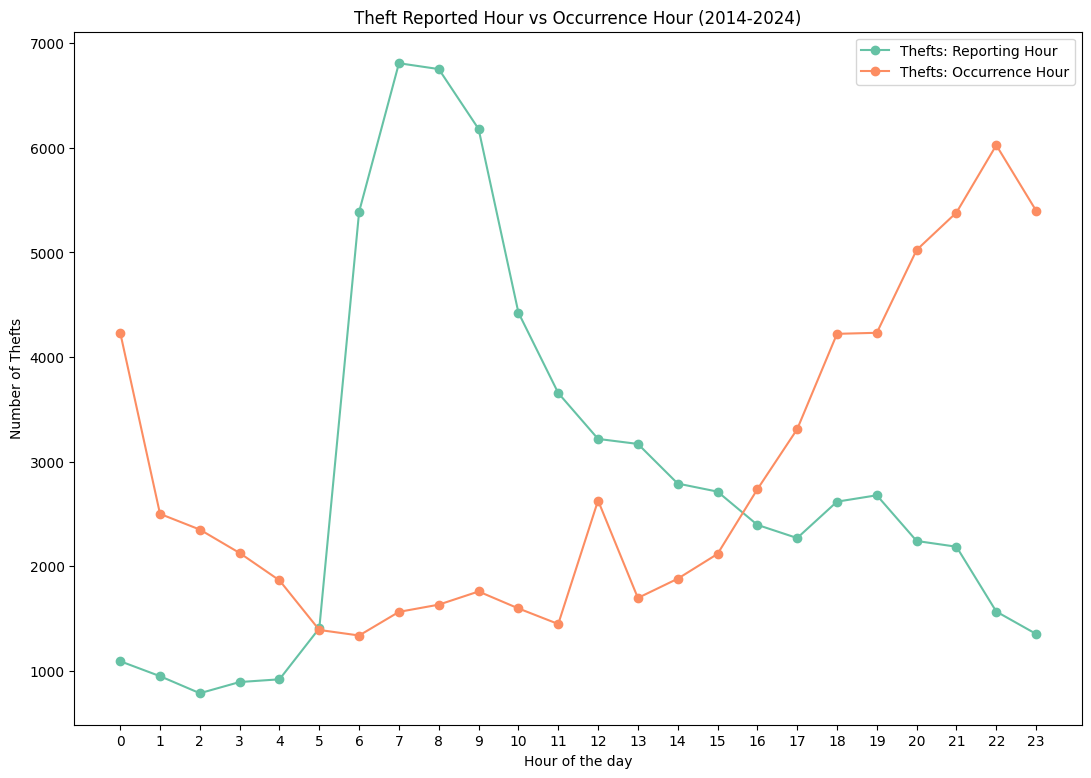

In [318]:
# Visualize hour of the day theft data. Compare Occurrence vs Reported Hour.
hourly_rep_data = auto_theft_data_filtered.groupby('REPORT_HOUR').size().rename('Thefts: Reporting Hour')
hourly_rep_data.plot(kind='line', xlabel='HOUR OF THE DAY', legend=True,
                     marker='o')

hourly_occ_data = auto_theft_data_filtered.groupby('OCC_HOUR').size().rename('Thefts: Occurrence Hour')
hourly_occ_data.plot(kind='line',  xlabel='Hour of the day', legend=True,
                     marker='o', xticks=range(0,24),
                     ylabel = 'Number of Thefts',
                     title='Theft Reported Hour vs Occurrence Hour (2014-2024)',
                     figsize=(13,9))

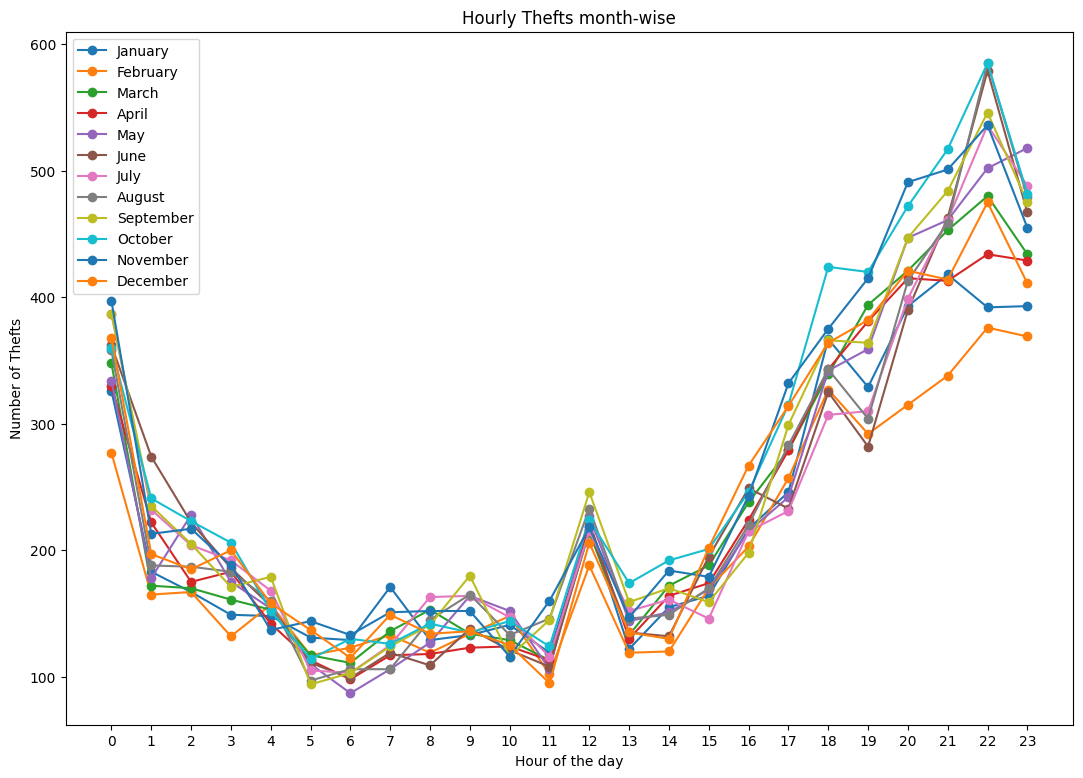

In [319]:
# Visualize hour of the day theft data by month.
import seaborn as sns
colors = sns.color_palette("tab10", 12)
for i, month in enumerate(month_order):
  monthly_data = auto_theft_data_filtered[auto_theft_data_filtered['REPORT_MONTH'] == month]
  hourly_data = monthly_data.groupby(['OCC_HOUR']).count()['EVENT_UNIQUE_ID']
  hourly_data.name = month
  hourly_data.plot(legend=True, figsize = (13,9), title='Hourly Thefts month-wise',
                  xlabel = 'Hour of the day', ylabel = 'Number of Thefts',
                  xticks=range(0,24), style='-', kind='line', marker='o', color=colors[i])


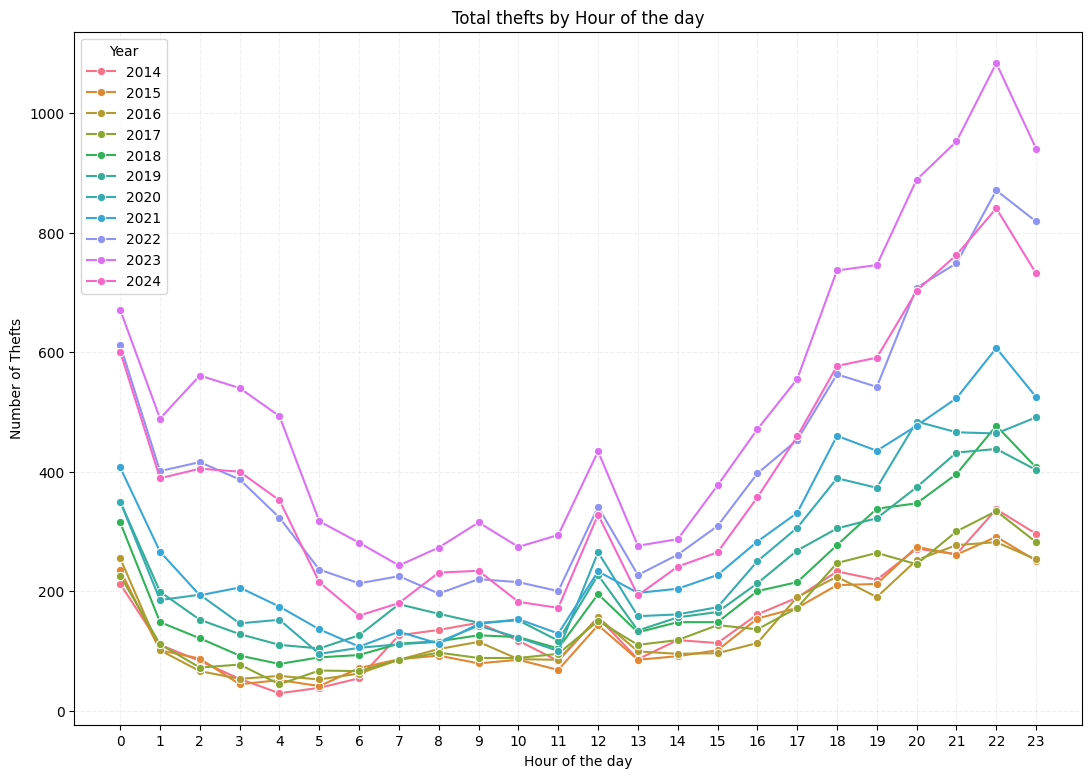

,OCC_HOUR,THEFT_COUNT
REPORT_YEAR,,
2014,22,337
2015,22,291
2016,22,282
2017,22,334
2018,22,477
2019,22,438
2020,23,491
2021,22,607
2022,22,871


In [320]:
# Visualize for a year and check if it displays similar trend
# Visualize hour of the day theft data by year. To be done per year as aggregate data might not be accurate
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

hourly_data_year = auto_theft_data_filtered.groupby(['REPORT_YEAR', 'OCC_HOUR']).size().reset_index(name='THEFT_COUNT')
hourly_data_year['REPORT_YEAR'] = hourly_data_year['REPORT_YEAR'].astype(str)
plt.figure(figsize=(13,9))
sns.lineplot(x = 'OCC_HOUR', y = 'THEFT_COUNT', hue ='REPORT_YEAR',
             data=hourly_data_year, marker='o')
plt.legend(title='Year', loc='best')
plt.title(f"Total thefts by Hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Number of Thefts")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()

#Get the Hour when the thefts are at peak
display(HTML("<span style='font-weight:bold; font-size:18px;'>Hour when the theft is at peak by year</span>"))
display(hourly_data_year.loc[hourly_data_year.groupby(['REPORT_YEAR'])['THEFT_COUNT'].idxmax()].set_index('REPORT_YEAR'))

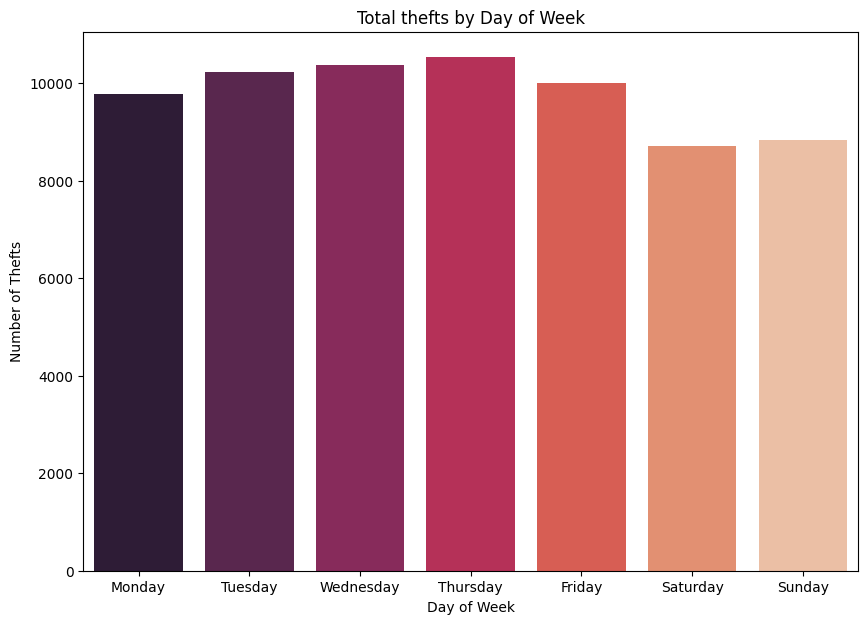

In [321]:
# Vidualize based on day of the week for all years
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
auto_theft_data_filtered.loc[:, 'OCC_DOW'] = auto_theft_data_filtered['OCC_DOW'].str.strip()
weekly_occ_df = auto_theft_data_filtered.groupby(['OCC_DOW']).size().reset_index(name='THEFT_COUNT')
weekly_occ_df['OCC_DOW'] = pd.Categorical(weekly_occ_df['OCC_DOW'], categories=week_order, ordered=True)
weekly_occ_df.sort_values('OCC_DOW', inplace=True)

plt.figure(figsize=(10,7))
sns.barplot(x='OCC_DOW', y='THEFT_COUNT', hue=x, data=weekly_occ_df, palette='rocket')
plt.title(f"Total thefts by Day of Week")
plt.xlabel('Day of Week')
plt.ylabel('Number of Thefts')
plt.show()

In [322]:
## Visualize data based on Division
division_data_yearly = auto_theft_data_filtered.groupby(['REPORT_YEAR', 'DIVISION']).size().reset_index(name='THEFTS')
division_data_yearly

plt.figure(figsize=(13,9))

#Creates a dropdown widget by default
@interact(year=division_data_yearly['REPORT_YEAR'].unique())
def plot_by_year(year):
    filtered = division_data_yearly[division_data_yearly['REPORT_YEAR'] == year]
    sorted = filtered.sort_values('THEFTS', ascending=False)
    sns.color_palette()
    sns.barplot(x='DIVISION', y='THEFTS', data=sorted, palette='YlOrRd_r',
                hue='DIVISION', legend=False)
    plt.title(f"Total Thefts per Division in {year}")
    plt.xticks(division_data_yearly['DIVISION'].unique())
    #plt.ylim(0, 1650)
    plt.show()

<Figure size 1300x900 with 0 Axes>

interactive(children=(Dropdown(description='year', options=(np.int64(2014), np.int64(2015), np.int64(2016), np…

# Visualize the Auto Thefts per division on a Map




In [323]:
## Step 1: Prepare Your Data
import geopandas as gpd
import pandas as pd

# Load GeoJSON and theft data
gdf = gpd.read_file('Police_Boundaries.geojson')  # must include 'division_id' and 'name'
df = division_data_yearly            # columns: division_id, year, theft_count
df = df.rename(columns={'DIVISION': 'DIV'})

# Convert GeoJSON to Web Mercator
gdf = gdf.to_crs(epsg=3857)

## Step 2: Function to Filter and Merge by Year

def get_geojson_for_year(selected_year):
    filtered_df = df[df['REPORT_YEAR'] == selected_year]
    merged = gdf.merge(filtered_df, on='DIV')
    return merged.to_json()

## Step 3: Set Up Bokeh Plot

from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, Slider, Button, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import column, row
import xyzservices.providers as xyz
from bokeh.io import curdoc

# Initial year
initial_year = df['REPORT_YEAR'].max()

# GeoJSONDataSource
geo_source = GeoJSONDataSource(geojson=get_geojson_for_year(initial_year))

# Color mapper. Set it in reverse order to reflect darker color for high density region.
color_mapper = LinearColorMapper(palette=YlOrRd9[::-1],
                                 low=df['THEFTS'].min(),
                                 high=df['THEFTS'].max())

# Create figure
p = figure(title="Theft Density by Division",
           x_axis_type="mercator", y_axis_type="mercator",
           width=800, height=600, tools="pan,wheel_zoom,reset")

p.add_tile(xyz.CartoDB.Positron)

# Add patches
p.patches('xs', 'ys', source=geo_source,
          fill_color={'field': 'THEFTS', 'transform': color_mapper},
          line_color='black', line_width=0.5, fill_alpha=0.7)

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0))
p.add_layout(color_bar, 'right')

# Add hover tool
hover = HoverTool(tooltips=[
    ("Division", "@DIV"),
    ("Thefts", "@THEFTS")
])
p.add_tools(hover)

## Step 4: Add Slider and Callback

# Create slider
year_slider = IntSlider(
    description = "Year",
    value = initial_year,
    min=df['REPORT_YEAR'].min(),
    max=df['REPORT_YEAR'].max(),
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Create table
table_source = ColumnDataSource()
columns = [
    TableColumn(field="RANK", title="RANK", width=50),
    TableColumn(field="DIVISION", title="Divisions", width=200),
    TableColumn(field="THEFTS", title="Theft Count", width=100),
]
data_table = DataTable(source=table_source,
                       columns=columns,
                       width=500,
                       height=600,
                       index_position=None)

layout = row(p, data_table)

#Create a handle to push changes to the notebook graph
handle = show(layout, notebook_handle=True)

@interact(year=year_slider)
def update_map(year):
  div_year = division_data_yearly[division_data_yearly['REPORT_YEAR'] == year].sort_values('THEFTS', ascending=False).reset_index(drop=True)
  div_year.index += 1
  div_year['RANK'] = div_year.index
  table_source.data = dict(ColumnDataSource(div_year).data)
  new_geojson = get_geojson_for_year(year)
  geo_source.geojson = new_geojson
  p.title.text = f"Theft Density by Division for {year}"
  push_notebook(handle=handle)

interactive(children=(IntSlider(value=2024, continuous_update=False, description='Year', max=2024, min=2014), …

# Visualize the Auto Thefts per Neighborhood on a Map
Identify Top 10 Neighborhoods with highest theft frequency




In [324]:
## Visualize data based on neighborhood data
from bokeh.models import ColumnDataSource, DataTable, TableColumn, Div

nhood_data_yearly = auto_theft_data_filtered.groupby(['REPORT_YEAR', 'NEIGHBOURHOOD_158']).size().reset_index(name='THEFTS')

# Load GeoJSON and theft data
gdf = gpd.read_file('Neighbourhoods.geojson')
gdf = gdf.rename(columns={'AREA_DESC' : 'NEIGHBOURHOOD_158'})
df = nhood_data_yearly            # columns: REPORT_YEAR, NEIGHBOURHOOD_158, THEFTS

# Convert GeoJSON to Web Mercator
gdf = gdf.to_crs(epsg=3857)

#Function to Filter and Merge by Year
def get_geojson_for_year(selected_year):
    filtered_df = df[df['REPORT_YEAR'] == selected_year]
    merged = gdf.merge(filtered_df, on='NEIGHBOURHOOD_158')
    return merged.to_json()

#Setup bokeh for visualization
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.palettes import YlOrRd9, inferno
from bokeh.io import curdoc

# Initial year
initial_year = df['REPORT_YEAR'].max()

# GeoJSONDataSource
geo_source = GeoJSONDataSource(geojson=get_geojson_for_year(initial_year))  # Must be in EPSG:4326

# Color mapper. Set it in reverse order to reflect darker color for high density region.
color_mapper = LinearColorMapper(palette=YlOrRd9[::-1],
                                 low=df['THEFTS'].min(),
                                 high=df['THEFTS'].max())

# Create figure (no Mercator, no tile)
p = figure(title="Theft Density by Neighbourhood",
           width=800, height=600,
           tools="pan,wheel_zoom,reset")

p.add_tile(xyz.OpenStreetMap.Mapnik)

# Add patches
p.patches('xs', 'ys', source=geo_source,
          fill_color={'field': 'THEFTS', 'transform': color_mapper},
          line_color='black', line_width=0.5, fill_alpha=0.7)

# Add color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0))
p.add_layout(color_bar, 'right')

# Add hover tool
hover = HoverTool(tooltips=[
    ("Neighborhood:", "@NEIGHBOURHOOD_158"),
    ("Thefts:", "@THEFTS")
])
p.add_tools(hover)

# Layout
curdoc().add_root(column(p))

# Create slider
year_slider = IntSlider(
    description = "Year",
    value = initial_year,
    min=df['REPORT_YEAR'].min(),
    max=df['REPORT_YEAR'].max(),
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Create table
table_source = ColumnDataSource()
columns = [
    TableColumn(field="RANK", title="RANK", width=50),
    TableColumn(field="NEIGHBOURHOOD_158", title="Top 10 Neighborhood", width=200),
    TableColumn(field="THEFTS", title="Theft Count", width=100),
]
data_table = DataTable(source=table_source,
                       columns=columns,
                       width=500,
                       height=400,
                       index_position=None)

layout = row(p, data_table)

#Create a handle to push changes to the notebook graph
handle = show(layout, notebook_handle=True)

@interact(year=year_slider)
def update_map(year):
  nhood_filtered = nhood_data_yearly[nhood_data_yearly['REPORT_YEAR'] == year]
  threshold = nhood_filtered['THEFTS'].quantile(0.94)
  vulnerable = nhood_filtered[nhood_filtered['THEFTS'] >= threshold].sort_values('THEFTS', ascending=False).reset_index(drop=True)
  vulnerable.index += 1
  vulnerable['RANK'] = vulnerable.index
  table_source.data = dict(ColumnDataSource(vulnerable).data)
  new_geojson = get_geojson_for_year(year)
  geo_source.geojson = new_geojson
  p.title.text = f"Theft Density by Neighborhood for {year}"
  push_notebook(handle=handle)


interactive(children=(IntSlider(value=2024, continuous_update=False, description='Year', max=2024, min=2014), …

# Analyze the type of location where Auto thefts occur

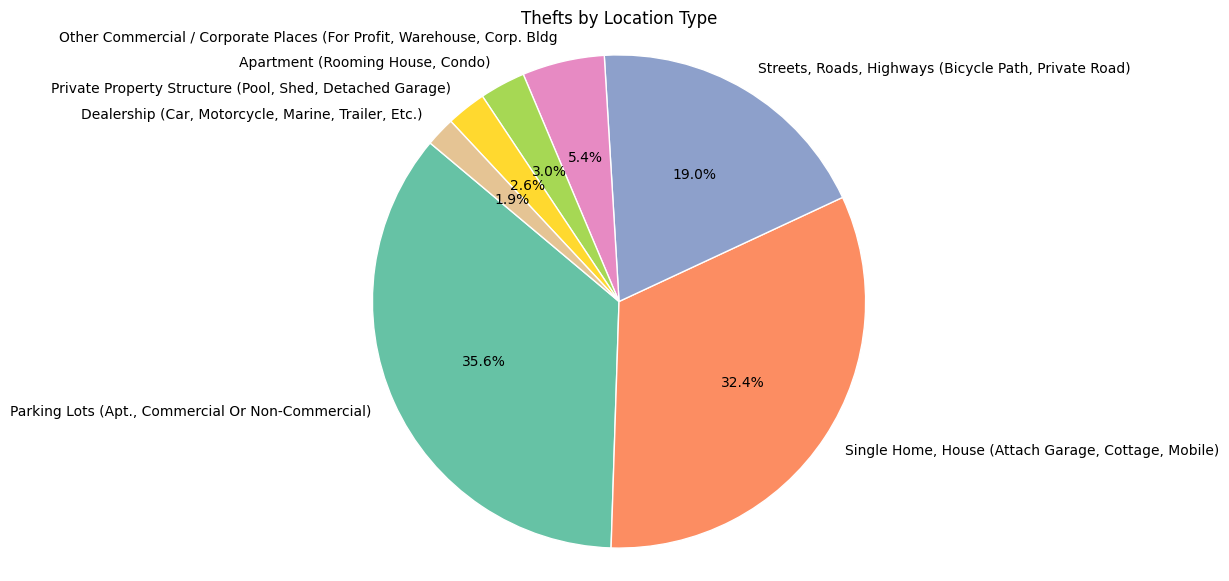

In [325]:
#Analyze Auto Theft data by location type for all years 2014-2024
df = auto_theft_data_filtered
df_grouped = df.groupby(['LOCATION_TYPE']).size().sort_values(ascending=False).reset_index(name='THEFTS')
top_n = 7
df_top = df_grouped.head(top_n)

colors = cividis
plt.figure(figsize=(7,7))
plt.pie(df_top['THEFTS'], labels=df_top['LOCATION_TYPE'],
        autopct='%1.1f%%', shadow=False, startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
plt.title('Thefts by Location Type')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()



In [ ]:
## Displaying all the Auto Thefts for 2014-2024 in Maps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

c_1 = folium.Map(location=[43.75,-79.30], tiles='openstreetmap', zoom_start=11)
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['LONG_WGS84']) and not math.isnan(row['LAT_WGS84']):
        mc.add_child(Marker([row['LAT_WGS84'], row['LONG_WGS84']]))
#title to the map
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Total Auto thefts since 2014-2024 in Toronto</b></h3>
             '''
c_1.get_root().html.add_child(folium.Element(title_html))
c_1.add_child(mc)
